# Introduction
[PyTorch] is one of the two most popular Deep Learning frameworks in Python, besides TensorFlow. Here is some key points when comparing the two:
- In terms of low or high level, PyTorch falls somewhere in between TensorFlow and Keras. No fit-and-predict interface, must be done by hand.
- PyTorch is prefered by research community with more customizations, as we normally see newly published architectures written in PyTorch.
- TensorFlow/Keras is better for production due to high-level interface and large deployment ecosystem.

[PyTorch]: https://github.com/pytorch/pytorch

# 1. Data manipulation

## 1.1. Computation

In [1]:
import numpy as np
import pandas as pd
import janitor
import torch
import torch.nn as nn
import torch.nn.functional as F

### Tensor
In PyTorch, we work most of the time with
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/tensors.html>Tensor</a></code>
whose operations are very much like NumPy's array. Being very natural to PyTorch, tensor operations are provided directly in the [mother package]. One thing to notice is that PyTorch requires tensors to be of the same data type so mathematical computation can be performed on them. When error occurs, simply call the <code style='font-size:13px'>double()</code> method to convert the tensor to float type.

[mother package]: https://pytorch.org/docs/stable/torch.html

In [40]:
a = torch.tensor([
    [1., 2., 3.],
    [4., 5., 6.]
])

In [41]:
torch.rand_like(a).double()

tensor([[0.1039, 0.6032, 0.2776],
        [0.3127, 0.8976, 0.3040]], dtype=torch.float64)

### Autograd
PyTorch provides automatic differentiation via the sub-module
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/autograd.html>autograd</a></code>,
with functions implemented as
<code style='font-size:13px'>Tensor</code>
methods. Being a mathematical module, it distinguishes two types of tensor, *constant* and *variable*, indicated via the flag <code style='font-size:13px'>requires_grad</code>. All tensors are constants by default, and become variables when this flag is enabled. Autograd is designed to work on a computational graph, where:
- The *foward* pass requires inputs to be tensors and output to be a scalar. This pass is done using normal tensor operations.
- During *backward* pass (by calling the <code style='font-size:13px'>backward()</code> method on the output), PyTorch will compute and accumulate partial derivatives for leaf nodes. This information can be accessed via the <code style='font-size:13px'>grad</code> attribute of input variables.

In [2]:
def f(x1, x2):
    y = (x1 - 0.3)**2 + (x2 - 0.7)**2 + 1
    return y.mean()

In [3]:
x1 = torch.rand(8, requires_grad=True)
x2 = torch.rand(8, requires_grad=True)

In [4]:
y = f(x1, x2)
y.backward()
x1.grad

tensor([ 0.0980,  0.0163,  0.0375,  0.0945, -0.0603, -0.0421,  0.0848,  0.0035])

### Optimization
The sub-module <code style='font-size:13px'><a href=https://pytorch.org/docs/stable/optim.html>optim</a></code>
implements various optimization algorithms from the basic SGD to the standard Adam. We are going to demonstrate
<code style='font-size:13px'>autograd</code> and <code style='font-size:13px'>optim</code>
combining together using a simple problem, finding $\min\bar{\mathbf{y}}$ where $\mathbf{y}=(\mathbf{x}_1-0.3)^2+(\mathbf{x}_2-0.7)^2+1$. Recall that all gradient descent algorithms share three components:
- (1) configurations such as learning rate $\eta$, momentum $\gamma$ and weight decay $\rho$
- (2) the variable $x_t$ and its gradient $g_t$ at each iteration $t$
- (3) intermediate variables such as exponential moving averages $m$ and $v$

PyTorch implements its optimization algorithms in a low-level interface. During initialization, we set component (1) and register component (2) to our optimizer. Then, when we call the
<code style='font-size:13px'>step()</code>
method, PyTorch will compute everything needed in component (3) and perform update in-place to $x$.

The registration step surprisingly makes sense, as we realize that gradient descent actually only cares about $x$ and never touches $y$. The optimization process is very clearly here: Autograd handles computational graphs to updates $g_t$, then Optim uses $g_t$ to perform a gradient descent step and passes the updated $x_t$ back to Autograd. We can see how smartly PyTorch is designed, each sub-module is account for a specific task, they alternately do their jobs and pass the output to the other. Learning optimization in PyTorch makes understanding about gradient descent much deeper.

In [3]:
def f(x1, x2):
    y = (x1 - 0.3)**2 + (x2 - 0.7)**2 + 1
    return y.mean()

In [13]:
x1 = torch.rand(8, requires_grad=True)
x2 = torch.rand(8, requires_grad=True)
params = (x1, x2)
optimizer = torch.optim.SGD(params, lr=0.3)

In [14]:
nIter = 50
for _ in range(nIter):
    optimizer.zero_grad()
    y = f(x1, x2)
    y.backward()
    optimizer.step()

In [15]:
y

tensor(1.0001, grad_fn=<MeanBackward0>)

In [16]:
x1

tensor([0.2962, 0.3104, 0.3003, 0.2940, 0.2979, 0.3084, 0.2987, 0.3042],
       requires_grad=True)

In [ ]:
x2

tensor([0.6955, 0.6917, 0.6884, 0.6930, 0.7044, 0.7018, 0.6859, 0.6970],
       requires_grad=True)

In [18]:
x1.grad

tensor([-1.0275e-03,  2.8155e-03,  8.2090e-05, -1.6275e-03, -5.5965e-04,
         2.2668e-03, -3.4240e-04,  1.1293e-03])

## 1.2. Data loader
The sub-module
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/data.html>utils.data</a></code>
provides abstract interface helping Data Scientists to work with different types of data. First, we create a dataset class by inherting
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset>Dataset</a></code>
and overriding two methods
<code style='font-size:13px'>\_\_len__()</code> and <code style='font-size:13px'>\_\_getitem__()</code>.
Then we pass this dataset to 
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>DataLoader</a></code>
to enable batch behaviour.

In [34]:
import numpy as np
import pandas as pd
import janitor

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [2]:
# constants
df = pd.read_csv('data/boston.csv')
df.head()

,crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
class TabularData(Dataset):
    def __init__(self, df, labelName):
        self.samples = df.drop(columns=labelName)
        self.samples = torch.tensor(self.samples.values, dtype=torch.float32)
        self.labels = df[labelName]
        self.labels = torch.tensor(self.labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        return sample, label

dataset = TabularData(df, 'price')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
class LinearRegression(nn.Module):
    def __init__(self, nFeatures):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(nFeatures))
        self.bias = nn.Parameter(torch.rand(1))
        
    def forward(self, x):
        yHat = x @ self.weight + self.bias
        return yHat

model = LinearRegression(nFeatures=13)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [74]:
w = torch.zeros(13, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

params = w, b
optimizer = torch.optim.Adam(params, lr=0.5)

In [75]:
criterion = nn.MSELoss()
listLoss = []

nEpoch = 20
for epochNum in range(1, nEpoch+1):
    for batchNum, (x, y) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        yHat = x@w + b
        loss = criterion(yHat, y)
        loss.backward()
        optimizer.step()
        listLoss.append(loss.item())

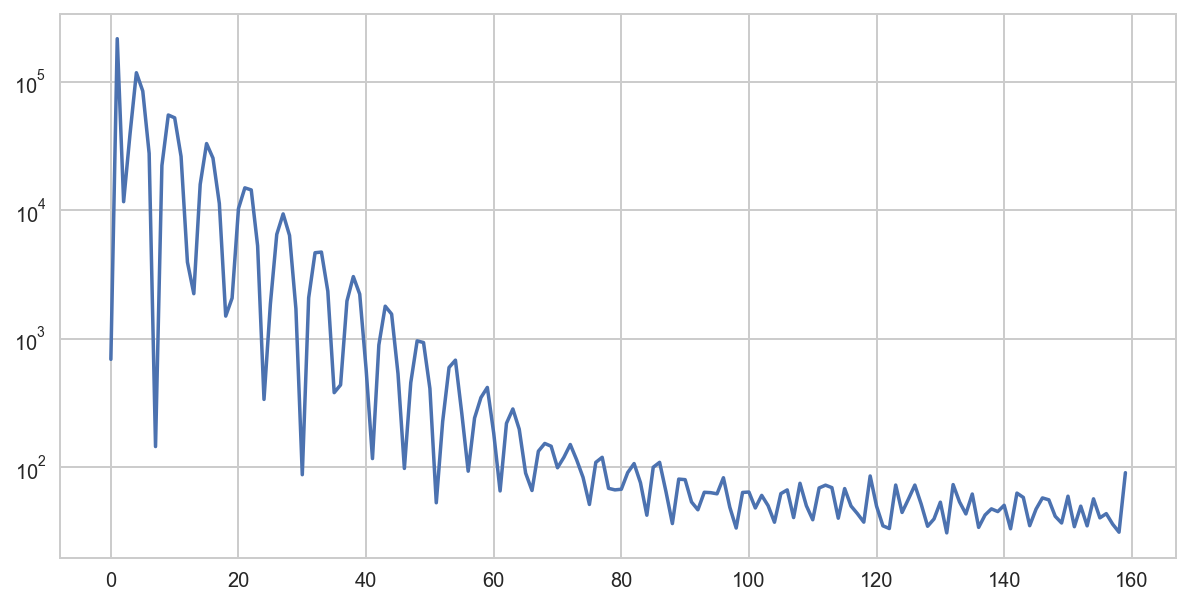

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(listLoss)
ax.set_yscale('log')
plt.show()

### Gradient accumulation
We might notice that at some points in the training loop, we call the method
<code style='font-size:13px'>zero_grad()</code>
on the optimizer.

## (w) Language processing
<code style='font-size:13px'><a href=https://pytorch.org/text/stable/index.html>torchtext</a></code>

## (w) Image processing
<code style='font-size:13px'><a href=https://pytorch.org/vision/stable/index.html>torchvision</a></code>

# (w) Neural networks

PyTorch has two APIs for creating layers,
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/nn.html>nn</a></code>
(abbreviated for *neural network*) and
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/nn.functional.html>nn.functional</a></code>.
The first module provides object interface (that supports auto differentiation) and the second module provides function interface (easier to use). So, the best practice is using object interface for layers with trainable parameters such as recurrent or convolutional, and using function interface for loss functions or activation functions.

PyTorch has two APIs for creating models, where the recommended one is
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/generated/torch.nn.Module.html>nn.Module</a></code>,
being equivalent to functional API in Keras. To create a model, we inherit this class, define building blocks inside the <code style='font-size:13px'>\_\_init__()</code> method and design the neural network architecture with the <code style='font-size:13px'>foward()</code> method. We don't need to to specify the backward pass, as the submodule
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/autograd.html>autograd</a></code>
will handle it for us. The second API,
<code style='font-size:13px'><a href=https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html>nn.Sequential</a></code>,
is good for simple architectures as well as small blocks of large networks, inception block of GooLeNet for example.

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

In [2]:
torch.cuda.is_available()

False

In [56]:
x = torch.autograd.Variable(torch.Tensor([[1,2,3,4,5]]), requires_grad=True)
y = torch.sum(x**2)
y.backward() 
x.grad

tensor([[ 2.,  4.,  6.,  8., 10.]])

In [57]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.

        D_in: input dimension
        H: dimension of hidden layer
        D_out: output dimension
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H) 
        self.linear2 = nn.Linear(H, D_out)

def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must 
        return a Variable of output data. We can use Modules defined in the 
        constructor as well as arbitrary operators on Variables.
        """
        h_relu = nn.functional.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

In [72]:
class Rectangle:
    def __init__(self, length, width):
        self.length = length
        self.width = width

    def area(self):
        return self.length * self.width

    def perimeter(self):
        return 2 * self.length + 2 * self.width

class Square(Rectangle):
    def __init__(self, length):
        super().__init__(length, length)
        
class Cube(Square):
    def surface_area(self):
        face_area = super().area()
        return face_area * 6

    def volume(self):
        face_area = super().area()
        return face_area * self.length

# References
- *pytorch.org - [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html)*
- *pytorch.org - [Automatic differentiation with Torch.Autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)*
- *pytorch.org - [Deep Learning with PyTorch: A 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)*
- *towardsdatascience.com - [Understanding PyTorch with an example: a step-by-step tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)*
- *towardsdatascience.com - [PyTorch vs TensorFlow - spotting the difference](https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)*
- *blog.paperspace.com - [PyTorch 101 advanced](https://blog.paperspace.com/pytorch-101-advanced/)*
- *poloclub.github.io - [CNN explainer](https://poloclub.github.io/cnn-explainer/)*
- https://cs230.stanford.edu/blog/pytorch/

In [ ]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [ ]:
!pip3 install torch torchvision torchaudio --user

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*